In [73]:
using CSV, DataFrames
using FileIO, Dates
using Plots

In [74]:
include("./src/cubes.jl")
include("./src/network.jl")
include("./src/motifs_discovery.jl")
include("./src/motifs_analysis.jl")

volume_tetrahedrons (generic function with 1 method)

In [3]:
path = "./data/"
name = "italy"
filepath = path * name * ".csv"

italy_full = CSV.read(filepath, DataFrame);

italy = italy_full[(italy_full.Depth .>= 0.0),:];

italy, italy_cubes = region_cube_split(italy,side=10,energyRelease=false);

MG = create_network(italy, italy_cubes; edgeWeight=false)
connectivity = degree(MG);

"./data/italy.csv"

In [108]:
using DataStructures

In [109]:
c = DataStructures.counter(fit_data)

Accumulator{Int64, Int64} with 184 entries:
  56  => 8
  35  => 25
  60  => 10
  220 => 2
  67  => 4
  215 => 2
  73  => 4
  185 => 2
  86  => 5
  224 => 1
  12  => 236
  75  => 3
  23  => 54
  111 => 1
  41  => 10
  68  => 3
  82  => 1
  130 => 1
  125 => 2
  ⋮   => ⋮

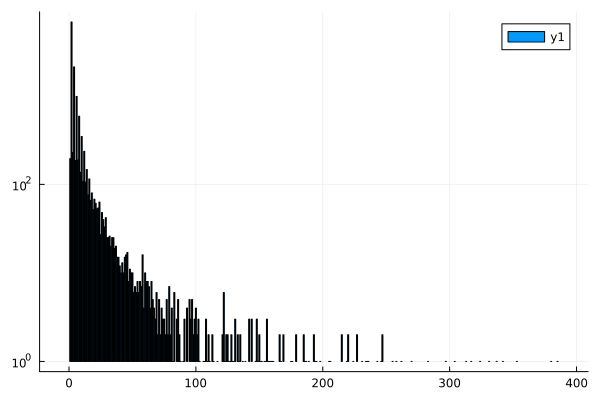

In [112]:
bar(collect(keys(c)), collect(values(c)),yscale=:log10)

In [123]:
using PyCall

In [124]:
powerlaw = pyimport("powerlaw")

PyObject <module 'powerlaw' from 'C:\\Users\\gabipana\\.julia\\conda\\3\\lib\\site-packages\\powerlaw.py'>

In [125]:
py"""
import powerlaw as powerlaw
def fit_data_powerlaw(fit_data):
    results = powerlaw.Fit(fit_data)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    print(results.power_law.alpha)
    print(results.power_law.xmin)
    R, p = results.distribution_compare('power_law', 'lognormal')
    return alpha, xmin

def plot_pdf(fit_data):
    pdf = powerlaw.pdf(fit_data)
    return pdf
"""

In [126]:
alpha, xmin = py"fit_data_powerlaw"(fit_data)

Calculating best minimal value for power law fit
C:\Users\gabipana\.julia\conda\3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


(2.4074289949031984, 20.0)

In [127]:
pdf = py"plot_pdf"(fit_data)

([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 13.0, 17.0  …  45.0, 57.0, 72.0, 92.0, 117.0, 148.0, 188.0, 239.0, 303.0, 385.0], [0.013962480309322641, 0.4884720034369182, 0.016396964055563512, 0.15179722182443076, 0.013318058141200058, 0.04203064585421738, 0.025955892882715166, 0.016492434006396488, 0.007947873406845196, 0.00468280108835744  …  0.001102677932120865, 0.0006742565277578882, 0.00046302926153993034, 0.00020048689674924817, 0.00012602033509952743, 8.546100437467952e-5, 5.549190892166691e-5, 2.807939730381627e-5, 1.1187884863239296e-5, 8.732007698137987e-6])

In [128]:
function power_law(x,a)
    return x .^(-a)
end

power_law (generic function with 2 methods)

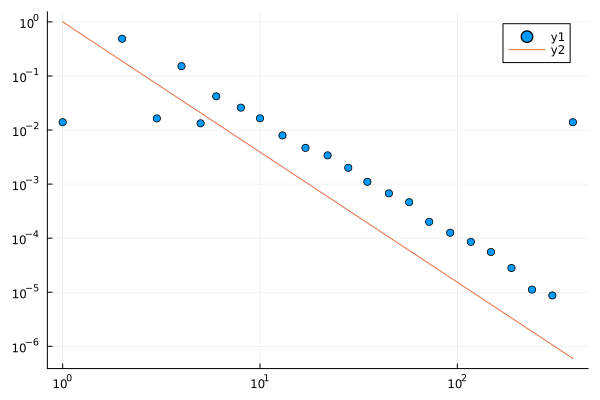

In [129]:
scatter(pdf,xscale=:log10, yscale=:log10)
#plot!(pdf[1],power_law(pdf[1],alpha))
plot!(fit_data,power_law(fit_data,alpha))

In [130]:
# pdf[1]
# findfirst(item -> item >= xmin, pdf[1])
# pdf_cutoff = pdf[1][findfirst(item -> item >= xmin, pdf[1]) : end]
# scatter(pdf,xscale=:log10, yscale=:log10)
# plot!(pdf_cutoff,power_law(pdf_cutoff,alpha))

In [113]:
include("./src/histogram_fit.jl")

power_law (generic function with 2 methods)

In [114]:
h, x,y = histogram_fit(fit_data)

(Histogram{Float64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  1.0:0.33219975495191384:384.6907169694605
weights: [195.0, 0.0, 0.0, 6822.0, 0.0, 0.0, 229.0, 0.0, 0.0, 2120.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: false, Any[1.1660998774759568], [1.0])

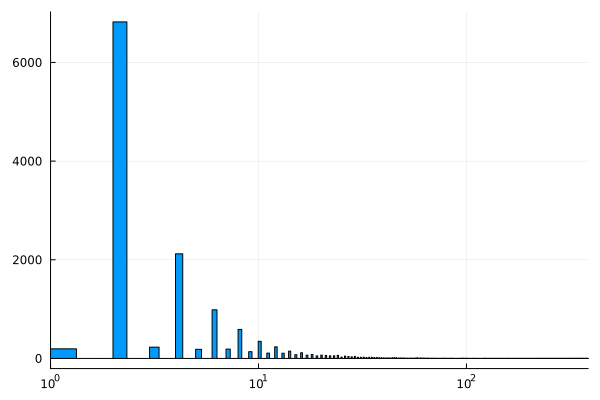

In [115]:
plot(h ; label="",xscale=:log10, xlim=extrema(fit_data))

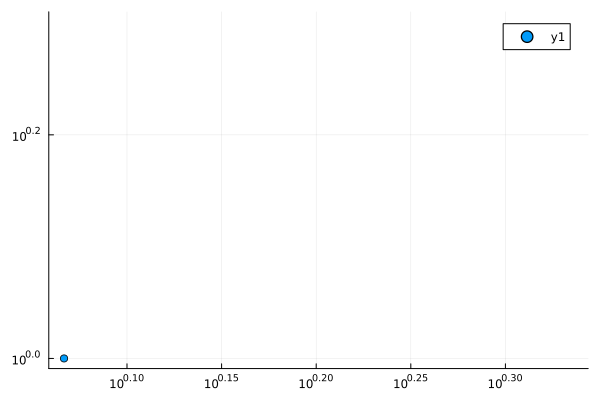

In [116]:
scatter(x,y,xscale=:log10,yscale=:log10)

In [117]:
# bstep = 2 * iqr(fit_data) * length(fit_data) ^ (-1/3)
# b = minimum(fit_data) : bstep : maximum(fit_data)
h = StatsBase.fit(Histogram{Float64}, fit_data, nbins=ceil(sqrt(length(fit_data))))


# Collect bin edges and calculate middle between each 2 points
xx = collect(h.edges[1])
x=[]
for i in eachindex(xx[1:end-1])
    push!(x,(xx[i]+xx[i+1])/2)
end
# Results x, the middle of each bin

# Collect bin weights (number of counts in each bin)
y = h.weights

# Code for stoping at first zero (apply to both vectors)
y_nozero=[]
x_nozero=[]
for i in eachindex(y)
    if y[i] == 0.0
        y_nozero = y[2:i-1]
        x_nozero = x[2:i-1]
        break
    end
end

# Normalize the bin weights (so they add up to 1)
y_nozero_norm = LinearAlgebra.normalize(y_nozero);

x = x_nozero
y = y_nozero_norm;

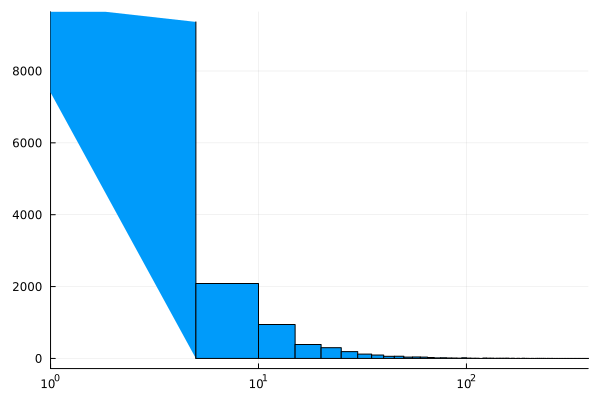

In [118]:
plot(h ; label="",xscale=:log10, xlim=extrema(fit_data))

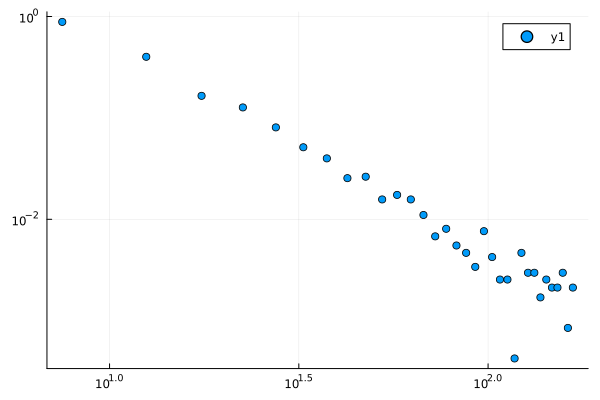

In [119]:
scatter(x,y,xscale=:log10,yscale=:log10)

In [120]:
using CurveFit

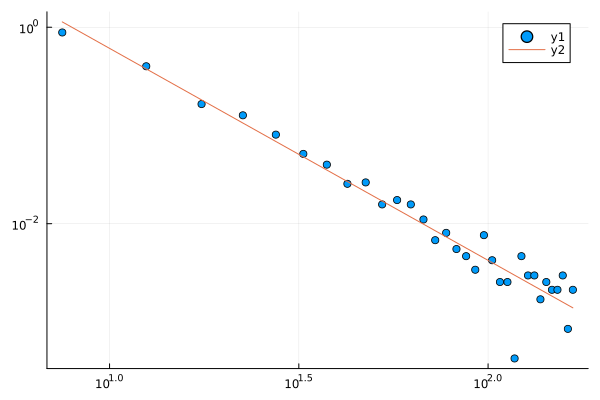

In [121]:
parameters = CurveFit.power_fit(x, y)

scatter(x, y,xscale=:log10,yscale=:log10)
plot!(x,power_law(x,parameters[1],parameters[2]))

In [122]:
parameters

(87.69490275464604, -2.158227084112328)